In [1]:
from utils import *
from speedup import *
from generate_kmer import *

ref_path = "/v/projects/nanopore/balazs/scripts/07_new_dataset/references/1015-1541_7-mer_500-reads_7-min-overlap.txt"
dorado_fastq_path = "/v/volumes/nanopore/timin_uracil/oligos/timin20250417/basecall/20250507/bam_to_fastq/calls_2025-05-08_T08-20-58.fastq"

sliding_window_result_path = "/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/sliding_window_result.txt"
ref_kmer_count_path = "/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/reference_kmer_count.txt"
read_kmer_count_path = "/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/read_kmer_count.txt"
kmmer_matches_path = "/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/matches.txt"

def contains_sliding_window(text, pattern, ):
    n, m = len(text), len(pattern)
    if m>n:
        return False
    for i in range(n-m+1):
        if text[i:i+m] == pattern:
            return i
    return False

def open_kmer_counts(file_path, total_lines=int(1e10)):
    kmer_counts=[]
    with open(file_path, "r") as f:
        for line in tqdm(f, total=total_lines, desc="Loading k-mer counts"):
            # Split the line into kmer:count pairs
            count_dict = {pair.split(":")[0]: int(pair.split(":")[1]) 
                          for pair in line.strip().split("\t") if pair}
            kmer_counts.append(count_dict)
    
    return np.array(kmer_counts, dtype=object)

def similarity(d1, d2, similarity_type='shared_count'):
    if similarity_type=='jaccard':
        keys1, keys2 = set(d1), set(d2)
        if not keys1 and not keys2:
            return 1.0
        return len(keys1 & keys2) / len(keys1 | keys2)
    elif similarity_type=='cosine': 
        from math import sqrt
        all_keys = set(d1) | set(d2)
        dot = sum(d1.get(k,0)*d2.get(k,0) for k in all_keys)
        norm1 = sqrt(sum(v*v for v in d1.values()))
        norm2 = sqrt(sum(v*v for v in d2.values()))
        return dot / (norm1*norm2) if norm1 and norm2 else 0.0
    elif similarity_type=='shared_count': 
        return len(set(d1).intersection(d2)) / len(d2)
    else:
        raise ValueError(f"similarity_type must be in ['jaccard', 'cosine', 'shared_count'], not '{similarity_type}'")

def calc_similarity(input_path, output_path, 
                    reference, 
                    total_lines=int(1e10), 
                    k=7, possible_bases='ATCG', 
                    similarity_type='shared_count', 
                    threshold = 0.7
                    ):
    heptamers = set(generate_k_mer_list(possible_bases, k))  
    with open(input_path, "r") as f_in:
        with open(output_path, "w") as f_out:
            for i, line in tqdm(enumerate(f_in), total=total_lines, desc="Calculating similarity."):
                read_dict = {pair.split(":")[0]: int(pair.split(":")[1]) 
                              for pair in line.strip().split("\t") if pair}
                for j, ref_dict in enumerate(reference):
                    sim = similarity(read_dict, ref_dict, similarity_type=similarity_type)
                    if sim >= threshold:
                        f_out.write(f"{i}\t{j}\t{sim:.4f}\n")

--- Warning! This version of speedup.py can cause errors. ---


```python
reference=[]
with open(ref_path, 'r') as file:
    for line in file:
        reference.append(line.strip())

```python
%%time
read_id   = []
read_seq  = []
#read_qual = []

FIRST_N_READS=int(1e10)

def decode_qual_string(qual_string):
    return [ord(char) - 33 for char in qual_string]

finish_counter=0
with open(dorado_fastq_path, 'r') as file:
    while finish_counter<FIRST_N_READS:
        header = file.readline().strip()
        if not header:
            break
        read_id.append(header[1:])
        sequence = file.readline().strip()
        read_seq.append(sequence)
        plus_line = file.readline().strip()
        quality = file.readline().strip()
        #read_qual.append(decode_qual_string(quality))
        finish_counter+=1

read_seq = np.array(read_seq, dtype=object)

---
# Exact macthes with sliding window

```python
sliding_window_result = []
start_with=200000
end_with=start_with+50000

with open(sliding_window_result_path, "a") as f:
    for i, read in tqdm(enumerate(read_seq[start_with:end_with]), total=len(read_seq[start_with:end_with]), desc="Processing"):
        for ref_id, ref in enumerate(reference):
            ref_start_pos = contains_sliding_window(read, ref)
            if ref_start_pos != False:
                f.write(f"{read_id[i+start_with]}\t{ref_id}\t{ref_start_pos}\n")
                break  
    f.write(f"#Checked until: {end_with}\n")
print(f"last run finished with variables 'start_with'={start_with} and 'end_with'={end_with}")

Processing: 100%|██████████| 60000/60000 [28:09<00:00, 35.52it/s] 
last run finished with variables 'start_with'=140000 and 'end_with'=200000

Processing: 100%|██████████| 965961/965961 [6:16:15<00:00, 42.79it/s]    
last run finished with variables 'start_with'=200000 and 'end_with'=1165961

Processing: 100%|██████████| 200000/200000 [1:15:34<00:00, 44.11it/s] 
last run finished with variables 'start_with'=1165961 and 'end_with'=1365961

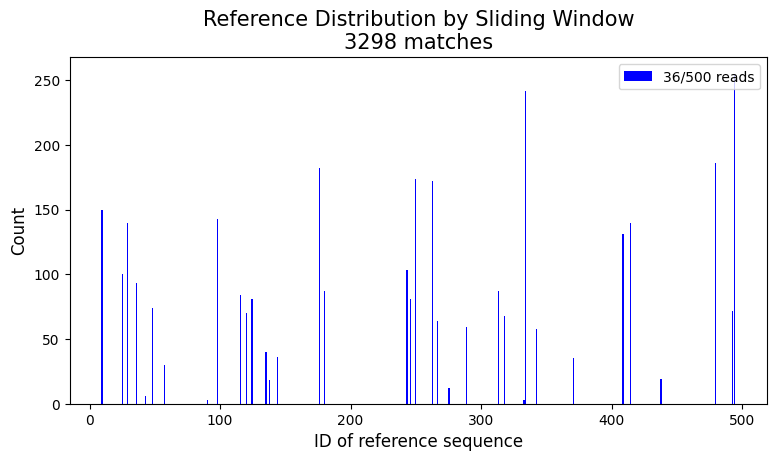

In [2]:
sliding_window_result = np.loadtxt(sliding_window_result_path, dtype=str, delimiter="\t", comments='#')
swr_read_ids = sliding_window_result[:, 0]
swr_ref_ids = sliding_window_result[:, 1].astype(int)
swr_ref_start_positions = sliding_window_result[:, 2].astype(int)


plt.figure(figsize=(9,4.5))
plt.hist(swr_ref_ids, bins=499, label=f'{len(np.unique(swr_ref_ids))}/500 reads', color='b')
plt.title(f'Reference Distribution by Sliding Window\n{len(swr_ref_ids)} matches', fontsize=FS+3)
plt.xlabel('ID of reference sequence', fontsize=FS)
plt.ylabel('Count', fontsize=FS)
plt.legend(loc='upper right')
plt.savefig('figures/sliding_window_result.pdf')
plt.show()

```python
def contains_sliding_window(text, pattern, ):
    n, m = len(text), len(pattern)
    
    if m>n:
        return False
    for i in range(n-m+1):
        if text[i:i+m] == pattern:
            return i
    return False
```

```python
sliding_window_result = []
start_with=16000

for i, read in tqdm(enumerate(read_seq[start_with:]), total=len(read_seq[start_with:]), desc='Processing'):
    for j, ref in enumerate(reference):
        x = contains_sliding_window(read, ref)
        if x!=False: break # only first match
    if x: sliding_window_result.append([read_id[i+start_with], j, x, i+start_with])

```python
sliding_window_result # read_id, ref_id, match_pos, read_index
reference[sliding_window_result[0][1]]
idx = sliding_window_result[0][3]
read_seq[idx][sliding_window_result[0][2]:len(reference[sliding_window_result[0][1]])+sliding_window_result[0][2]]

---
# Matches with k-mer similarity

```python
from collections import Counter

def kmer_count_in_sequences(read, k=7, possible_bases='ATCG', output_file=""):
    heptamers = set(generate_k_mer_list(possible_bases, k))  
    with open(output_file, "w") as f:
        for seq in tqdm(read, desc='Processing'):
            counts = {}
            seq_len = len(seq) - (k - 1)
            for i in range(seq_len):
                kmer = seq[i:i+k]
                if kmer in heptamers:
                    counts[kmer] = counts.get(kmer, 0) + 1
            
            f.write("\t".join(f"{k}:{v}" for k, v in counts.items()) + "\n")
    return None

kmer_count_in_sequences(reference, output_file=ref_kmer_count_path)
# Processing: 100%|██████████| 500/500 [00:00<00:00, 5498.62it/s]

kmer_count_in_sequences(read_seq, output_file=read_kmer_count_path)
# Processing: 100%|██████████| 1365961/1365961 [08:59<00:00, 2533.18it/s]

```python
ref_kmer_count = open_kmer_counts(ref_kmer_count_path, total_lines=500)

calc_similarity(read_kmer_count_path, kmmer_matches_path, ref_kmer_count, total_lines=1365961)
# Calculating similarity.: 100%|██████████| 1365961/1365961 [4:50:44<00:00, 78.31it/s]  

In [3]:
matches = []
with open(kmmer_matches_path, "r") as file:
    for line in file:
        cols = line.strip().split("\t")  # Split each line by tab
        numbers = list(map(float, cols))  # Convert to float (or int if appropriate)
        matches.append(numbers)

matches = np.array(matches)

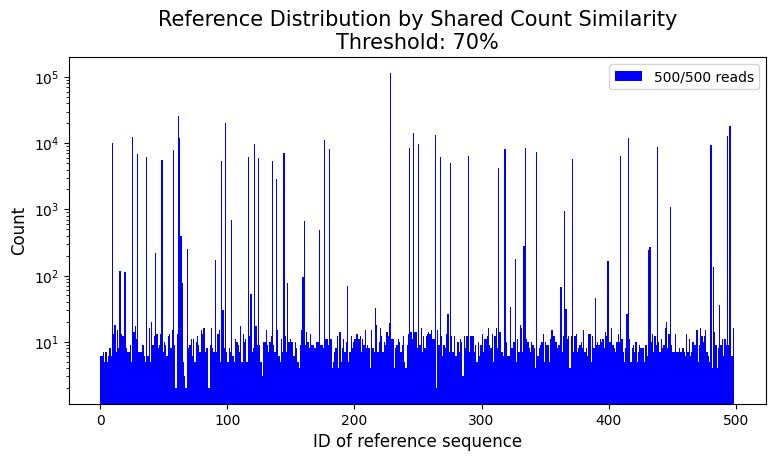

In [4]:
# minimal threshold
threshold = 0.7
idx = np.where(matches[:,2]>=threshold)[0]
plt.figure(figsize=(9,4.5))
plt.hist(matches[:,1][idx], bins=499, label=f'{len(np.unique(matches[:,1][idx]))}/500 reads', color='b')
plt.title(f'Reference Distribution by Shared Count Similarity\nThreshold: {threshold*100:.0f}%', fontsize=FS+3)
plt.xlabel('ID of reference sequence', fontsize=FS)
plt.ylabel('Count', fontsize=FS)
plt.yscale('log')
plt.legend(loc='upper right')
plt.savefig(f'figures/ref_seq_similarity_t={threshold*100:.0f}.pdf')
plt.show()

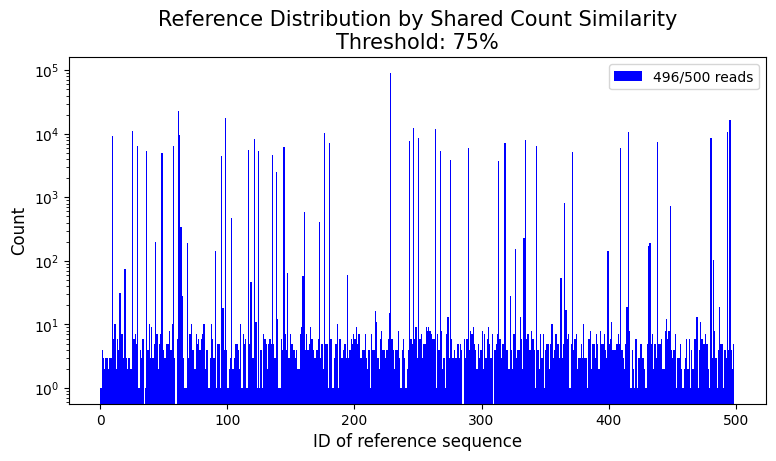

In [5]:
threshold = 0.75
idx = np.where(matches[:,2]>=threshold)[0]
plt.figure(figsize=(9,4.5))
plt.hist(matches[:,1][idx], bins=499, label=f'{len(np.unique(matches[:,1][idx]))}/500 reads', color='b')
plt.title(f'Reference Distribution by Shared Count Similarity\nThreshold: {threshold*100:.0f}%', fontsize=FS+3)
plt.xlabel('ID of reference sequence', fontsize=FS)
plt.ylabel('Count', fontsize=FS)
plt.yscale('log')
plt.legend(loc='upper right')
plt.savefig(f'figures/ref_seq_similarity_t={threshold*100:.0f}.pdf')
plt.show()

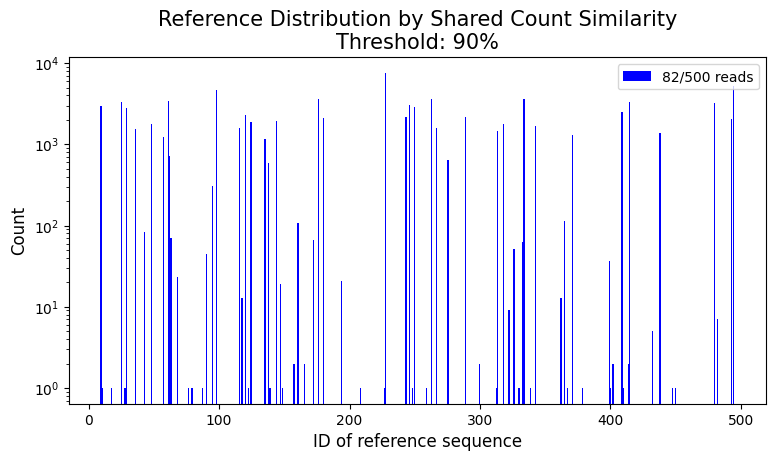

In [6]:
threshold = 0.9
idx = np.where(matches[:,2]>=threshold)[0]
plt.figure(figsize=(9,4.5))
plt.hist(matches[:,1][idx], bins=499, label=f'{len(np.unique(matches[:,1][idx]))}/500 reads', color='b')
plt.title(f'Reference Distribution by Shared Count Similarity\nThreshold: {threshold*100:.0f}%', fontsize=FS+3)
plt.xlabel('ID of reference sequence', fontsize=FS)
plt.ylabel('Count', fontsize=FS)
plt.yscale('log')
plt.legend(loc='upper right')
plt.savefig(f'figures/ref_seq_similarity_t={threshold*100:.0f}.pdf')
plt.show()

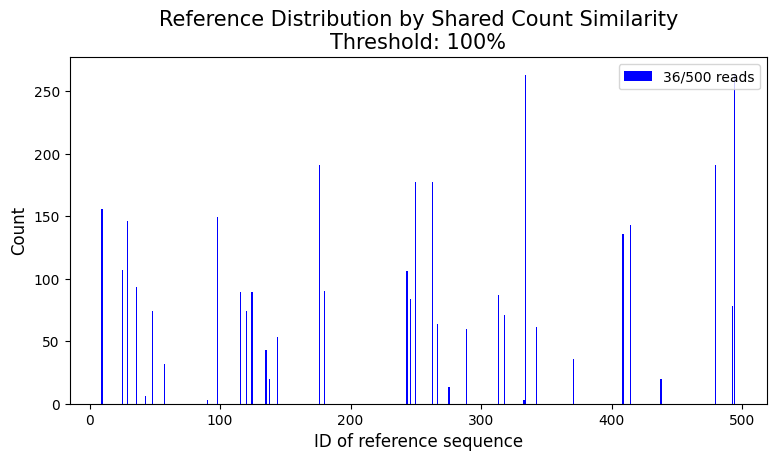

In [7]:
threshold = 1
idx = np.where(matches[:,2]>=threshold)[0]
plt.figure(figsize=(9,4.5))
plt.hist(matches[:,1][idx], bins=499, label=f'{len(np.unique(matches[:,1][idx]))}/500 reads', color='b')
plt.title(f'Reference Distribution by Shared Count Similarity\nThreshold: {threshold*100:.0f}%', fontsize=FS+3)
plt.xlabel('ID of reference sequence', fontsize=FS)
plt.ylabel('Count', fontsize=FS)
plt.legend(loc='upper right')
plt.savefig(f'figures/ref_seq_similarity_t={threshold*100:.0f}.pdf')
plt.show()